In [36]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from tqdm import tqdm
import numpy as np
import soundfile as sf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
import torch
import random

# MLP

A escolha do MLP como primeiro classificador fundamenta-se em três pilares principais:

**Baseline de Comparação:**
O MLP serve como um ponto de referência essencial. Permite-nos validar se as características estatísticas extraídas (médias e desvios padrão) possuem poder discriminativo suficiente antes de avançarmos para modelos computacionalmente mais pesados, como as CNNs.

**Classificação Baseada em Timbre:**
Muitos sons urbanos distinguem-se fundamentalmente pelo seu timbre e conteúdo espectral (ex: o ruído grave de um martelo pneumático vs. o som agudo de uma buzina). Como os descritores extraídos (MFCCs, Chroma) são representações matemáticas diretas desse timbre, o MLP atua como um classificador discriminativo ideal para aprender fronteiras de decisão nestes vetores de características densas.

**Natureza das Classes:**
Várias classes (como Air Conditioner, Engine Idling, Drilling) possuem texturas sonoras repetitivas ou estacionárias. Para estes sons, a assinatura espectral média (o "que" acontece) é mais relevante que a evolução temporal exata ("quando" acontece). O uso do MLP testa a hipótese de que modelar a sequência temporal complexa é desnecessário para distinguir estas categorias.

### Pré-processamento 

É fundamental garantir que todos os dados de entrada possuem uma taxa de amostragem uniforme. Diferentes taxas de amostragem resultam em vetores de características com escalas de frequência incomparáveis, o que impediria o modelo de aprender padrões consistentes.
Para determinar a taxa de amostragem ideal, realizámos uma análise espectral numa amostra representativa (500 aúdios aleatórios) do UrbanSound8K. O objetivo foi identificar a largura de banda onde reside a informação acústica relevante.

In [54]:
metadata_path = "UrbanSound8K/metadata/UrbanSound8K.csv"
audio_dir = "UrbanSound8K/audio"
df = pd.read_csv(metadata_path)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

df['file_path'] = df.apply(
    lambda row: os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name']),
    axis=1
)

In [4]:
def get_max_freq(audio_path, sr=44100, energy_percentile=95):
    y, sr = librosa.load(audio_path, sr=sr)
    # FFT
    spectrum = np.abs(np.fft.rfft(y))
    freqs = np.fft.rfftfreq(len(y), 1/sr)
    spectrum = spectrum / np.sum(spectrum)
    cumulative_energy = np.cumsum(spectrum)
    # Frequência onde atinge o percentil de energia desejado
    freq_limit = freqs[np.searchsorted(cumulative_energy, energy_percentile/100)]
    return freq_limit

# Exemplo com subset (para não ser muito lento)
sample_df = df.sample(500, random_state=42)  # 500 áudios aleatórios
results = []

for path in tqdm(sample_df['file_path'], desc="Calculando limite de frequência"):
    try:
        max_freq = get_max_freq(path)
        results.append(max_freq)
    except Exception as e:
        results.append(np.nan)

sample_df['max_freq'] = results
print(sample_df['max_freq'].describe())


Calculando limite de frequência: 100%|██████████| 500/500 [00:12<00:00, 41.56it/s]

count      500.000000
mean      9723.217791
std       4090.091536
min       1891.881166
25%       6453.187500
50%       9301.125000
75%      12933.937500
max      20149.035586
Name: max_freq, dtype: float64


A nossa análise revelou que 75% das amostras selecionadas concentram 95% da sua energia abaixo de 12,9 kHz, e a média é de 9,7 kHz.
Segundo o **Teorema de Nyquist-Shannon**, uma taxa de amostragem de **22050 Hz** (que capta até 11,025 kHz) é suficiente para representar a maioria dos sons do conjunto UrbanSound8K sem perda significativa de informação relevante.
Assim, esta taxa permite reduzir o custo computacional mantendo a fidelidade acústica essencial.

Definimos a função de normalização que será aplicada a todos os ficheiros de áudio. Este processo garante que o modelo recebe inputs uniformes e padronizados.

As etapas aplicadas a cada ficheiro são:

1. **Conversão para Mono:** Redução dos canais de áudio para um único canal, simplificando a entrada do modelo sem perda de informação crítica para a classificação de eventos sonoros.

2. **Reamostragem:** Conversão para a taxa de 22.050 Hz, conforme justificado acima.

3. **Normalização de Amplitude:** Ajuste dos valores da onda sonora para o intervalo [-1, 1], prevenindo distorções e facilitando a convergência do modelo.

4. **Padronização Temporal:** Ajuste da duração de todos os clipes para exatamente 4 segundos. Ficheiros mais curtos são preenchidos com silêncio (zero-padding) e ficheiros mais longos são truncados, assegurando vetores de entrada de tamanho fixo.

In [ ]:
# Diretórios
audio_dir = "UrbanSound8K/audio"
output_dir = "audio_processed"
os.makedirs(output_dir, exist_ok=True)

# Parâmetros
sample_rate = 22050
target_duration = 4.0

def preprocess_audio(file_path, sr=sample_rate, duration=target_duration):
    # Carregar áudio
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    
    # Normalizar amplitude
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    
    # Ajustar duração
    target_len = int(duration * sr)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]
    
    return y, sr

# Criar subpastas (folds)
for fold in range(1, 11):
    os.makedirs(os.path.join(output_dir, f"fold{fold}"), exist_ok=True)

# Aplicar processamento a todos os ficheiros
for _, row in df.iterrows():
    fold = row['fold']
    file_path = os.path.join(audio_dir, f"fold{fold}", row['slice_file_name']) 
    output_path = os.path.join(output_dir, f"fold{fold}", row['slice_file_name'])
    
    y, sr = preprocess_audio(file_path)
    sf.write(output_path, y, sr)

print("Pré-processamento concluído — ficheiros guardados em 'audio_processed'")

### Extração de features 

O modelo MLP não consegue interpretar áudio bruto (ondas sonoras no domínio do tempo). Para que o modelo possa aprender, é necessário converter o som em vetores numéricos de tamanho fixo que representem as suas propriedades acústicas.

Para tal, extraímos várias características de áudio e, para cada uma, calculámos a média e o desvio padrão ao longo do tempo. Isto permite resumir a informação temporal de todo o clipe num único vetor estatístico.

As features extraídas foram:
- **MFCCs (Mel-Frequency Cepstral Coefficients)** – representam a forma espectral, simulando a audição humana e são amplamente usados em reconhecimento de fala e som;
- **Features Chroma (STFT, CQT, CENS)** – capturam a distribuição de energia entre as notas da escala musical, úteis para sons harmónicos como sirenes e música;
- **Descritores Espectrais (centroid, bandwidth, contrast, rolloff)** – descrevem características físicas do espectro, como brilho ou dispersão;
- **RMS e ZCR** – medem a energia e o número de cruzamentos por zero (frequência de mudança de sinal), indicando intensidade e ruído.
- **Features Rítmicas (Tempogram & Fourier Tempogram)** - Capturam padrões repetitivos e o tempo/ritmo do áudio, cruciais para identificar sons mecânicos repetitivos (ex: drilling, jackhammer).

In [9]:
audio_dir = "audio_processed"
metadata_path = "UrbanSound8K/metadata/UrbanSound8K.csv"

def extract_audio_features(y, sr=sample_rate):
    """
    Extrai descritores acústicos de um sinal de áudio normalizado.
    Retorna um dicionário com valores médios e desvio padrão de cada feature.
    """
    features = {}
    
    # MFCCs 
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    for i in range(40):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        
    # Chroma features (informação harmónica) 
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    features['chroma_cqt_mean'] = np.mean(chroma_cqt)
    features['chroma_cqt_std'] = np.std(chroma_cqt)
    
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    features['chroma_cens_mean'] = np.mean(chroma_cens)
    features['chroma_cens_std'] = np.std(chroma_cens)
    
    # Descritores espectrais
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['rms_std'] = np.std(librosa.feature.rms(y=y))
    
    features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_centroid_std'] = np.std(librosa.feature.spectral_centroid(y=y, sr=sr))
    
    features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_bandwidth_std'] = np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    
    features['spectral_contrast_mean'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['spectral_contrast_std'] = np.std(librosa.feature.spectral_contrast(y=y, sr=sr))
    
    features['spectral_flatness_mean'] = np.mean(librosa.feature.spectral_flatness(y=y))
    features['spectral_flatness_std'] = np.std(librosa.feature.spectral_flatness(y=y))
    
    features['spectral_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['spectral_rolloff_std'] = np.std(librosa.feature.spectral_rolloff(y=y, sr=sr))
    
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y=y))
    features['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y=y))
    
    # Tempogram (mede a estrutura rítmica)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    features['tempogram_mean'] = np.mean(tempogram)
    features['tempogram_std'] = np.std(tempogram)
    
    # Fourier Tempogram (outra visão do ritmo) (números complexos)
    ft_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)
    # Guardamos a parte Real e Imaginária
    features['fourier_tempogram_real_mean'] = np.mean(np.real(ft_tempogram))
    features['fourier_tempogram_real_std'] = np.std(np.real(ft_tempogram))
    features['fourier_tempogram_imag_mean'] = np.mean(np.imag(ft_tempogram))
    features['fourier_tempogram_imag_std'] = np.std(np.imag(ft_tempogram))
    
    return features

#Extração de features
metadata = pd.read_csv(metadata_path)
all_features = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extraindo features"):
    file_path = os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name'])
    label = row['class']

    if not os.path.exists(file_path):
        continue

    y, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    feats = extract_audio_features(y, sr)
    feats['class'] = label
    feats['fold'] = row['fold']
    feats['file_name'] = row['slice_file_name']
    all_features.append(feats)

features_df = pd.DataFrame(all_features)
features_df.to_csv("features_audio.csv", index=False)

Extraindo features:   0%|          | 0/8732 [00:00<?, ?it/s]c:\Users\eduar\anaconda3\envs\urbansounds\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=384 is too large for input signal of length=173
  warnings.warn(
Extraindo features:   1%|          | 67/8732 [00:25<55:11,  2.62it/s]c:\Users\eduar\anaconda3\envs\urbansounds\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extraindo features: 100%|██████████| 8732/8732 [58:45<00:00,  2.48it/s]  


`Nota`: Conjuntos de Features para Testes

Embora o código acima mostre a extração completa de todas as características disponíveis, durante a fase de experimentação foram gerados três conjuntos distintos para avaliar o impacto da complexidade dos dados:

1. Simples: Apenas MFCCs (13 coeficientes), Chroma (STFT), Descritores Espectrais e RMS e ZCR.

2. Simples + Rítmicas: O conjunto anterior acrescido de Tempogram e Fourier Tempogram.

3. Completas (Código acima): Acrescido com 40 MFCCs, variantes extra de Chroma (CQT, CENS) e features rítmicas (Fourier separado em parte real e imaginária).

Os ficheiros CSV resultantes destas extrações (features_audio_simples.csv, etc.) foram salvos previamente e serão carregados diretamente na secção de Testes e Otimização.

In [38]:
df_simples = pd.read_csv("features_audio_simples.csv", nrows=0)
df_ritmicas = pd.read_csv("features_audio_simples_ritmicas.csv", nrows=0)
df_completas = pd.read_csv("features_audio_completas.csv", nrows=0)

# Contar features (Total colunas - 3 de metadados)
def count_feats(df):
    return df.shape[1] - 3  # Remove 'class', 'fold', 'file_name'

# Criar DataFrame de resumo
resumo_features = pd.DataFrame({
    'Dataset': ['Simples', 'Simples + Rítmicas', 'Completas'],
    'Total Colunas': [df_simples.shape[1], df_ritmicas.shape[1], df_completas.shape[1]],
    'Nº Features (Input)': [count_feats(df_simples), count_feats(df_ritmicas), count_feats(df_completas)],
})

# Mostrar a tabela
display(resumo_features)

,Dataset,Total Colunas,Nº Features (Input)
0,Simples,37,34
1,Simples + Rítmicas,41,38
2,Completas,109,106


### Model Architecture

O **Multi-Layer Perceptron (MLP)** é uma das arquiteturas fundamentais de redes neuronais artificiais. É composta por, pelo menos, três camadas de neurónios:
1.  **Camada de Entrada (Input Layer):** Recebe o vetor de *features* 1D. No nosso caso, este vetor contém as estatísticas (média e desvio padrão) extraídas dos ficheiros de áudio.
2.  **Camadas Ocultas (Hidden Layers):** Onde ocorre a extração de padrões não-lineares. Cada neurónio nestas camadas realiza uma soma ponderada das entradas seguida de uma função de ativação não-linear (como a **ReLU**).
3.  **Camada de Saída (Output Layer):** Produz a previsão final. Para classificação multiclasse (10 classes), utilizamos a função de ativação **Softmax**, que converte os *outputs* numa distribuição de probabilidades que somam 1.

O treino do MLP é realizado através do algoritmo de **Backpropagation**, utilizando um otimizador (**Adam**) para minimizar uma função de perda (no nosso caso, `sparse_categorical_crossentropy`).

Implementámos três variantes da arquitetura MLP para testar diferentes estratégias:
1.  **Baseline:** 3 camadas ocultas com Dropout. Baseámo-nos no artigo “A Review on Dropout Regularization Approaches for Deep Neural Networks” (MDPI, 2023), que confirma que o Dropout é uma das técnicas mais eficazes para reduzir o overfitting em redes totalmente conectadas, melhorando a robustez e a capacidade de generalização das arquiteturas MLP.
2.  **With Batch Normalization (BN):** Adiciona camadas de normalização após cada ativação ReLU para estabilizar o treino. A inclusão de camadas de normalização baseou-se nos conteúdos lecionados nas aulas teóricas (Machine Learning II — T04, “Regularization and Advanced Training Techniques”), onde é destacada a rapidez do treino, a melhoria do fluxo de gradientes e menor sensibilidade à inicialização.
3.  **With L2 Regularization:** O estudo “Multilayer Perceptron Explained & How To Train MLPs” destaca que a regularização L2 ajuda a controlar a magnitude dos pesos e reduzindo a complexidade do modelo.

Apesar de o estudo considerar também L1 regularization, optámos por não a incluir no nosso projeto por não ser a técnica mais adequada ao tipo de dados nem aos objetivos definidos. As nossas features são densas e não esparsas, pelo que a principal vantagem da L1 — indução de sparsity — não traria benefício relevante na representação acústica. Além disso, pretendíamos reduzir overfitting sem limitar excessivamente a expressividade do modelo; nesse sentido, a L2 é mais apropriada, pois suaviza os pesos sem os anular.

In [39]:
def build_MLP_baseline(input_neurons, hidden_units, output_neurons, learning_rate, dropout):
    """Modelo original, com 3 camadas."""
    model = tf.keras.models.Sequential([
        Input(shape=(input_neurons,)),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout),
        Dense(output_neurons, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_MLP_with_BN(input_neurons, hidden_units, output_neurons, learning_rate, dropout):
    """Modelo com Batch Normalization."""
    model = tf.keras.models.Sequential([
        Input(shape=(input_neurons,)),
        Dense(hidden_units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(hidden_units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(hidden_units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(output_neurons, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_MLP_with_L2(input_neurons, hidden_units, output_neurons, learning_rate, dropout, l2_lambda):
    """Modelo com Regularização L2."""
    model = tf.keras.models.Sequential([
        Input(shape=(input_neurons,)),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout),
        Dense(output_neurons, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Pipeline de Treino e Avaliação (K-Fold CV)

Para garantir uma avaliação robusta, implementámos a função `run_experiment`. Esta função executa uma **Validação Cruzada de 10 Folds**, garantindo que:
1.  **Pré-processamento Isolado:** O balanceamento (SMOTE) e a normalização (MinMaxScaler) são aplicados dentro de cada fold, usando apenas os dados de treino para evitar *data leakage*.
2.  **Validação Robusta:** O *Early Stopping* monitoriza um conjunto de validação dedicado (não o conjunto de teste) para prevenir *overfitting*.
3.  **Métricas Globais:** No final, agrega as previsões de todos os folds para gerar um relatório de classificação e matriz de confusão globais.

In [40]:
def run_experiment(model_builder_fn, hidden_units, learning_rate, dropout_rate, batch_size=32, l2_lambda=0.001):
    """
    Executa um 10-Fold CV completo, usando a lógica correta 8/1/1 (Train/Val/Test).
    Imprime os resultados no final.
    
    Args:
        model_builder_fn: constrói o modelo (ex: build_MLP_baseline).
        (outros hiperparâmetros)
    """
    
    fold_accuracies = []
    fold_losses = []
    all_y_test = np.array([])
    all_y_pred = np.array([])

    print(f"Experimento: {model_builder_fn.__name__} ")
    print(f"Params: hidden units={hidden_units}, learning rate={learning_rate}, dropout={dropout_rate}, batch size={batch_size}")
    if model_builder_fn.__name__ == "build_MLP_with_L2":
        print(f"L2 Lambda: {l2_lambda}")
        
    for fold_num in range(1, 11):
        print(f"\nFold {fold_num}/10 ")
        
        # 1. Divisão Correta (8/1/1)
        test_fold = fold_num
        val_fold = (fold_num % 10) + 1 # Usa o fold seguinte (dando a volta no 10)
        
        test_indices = np.where(fold_values == test_fold)[0]
        val_indices = np.where(fold_values == val_fold)[0]
        
        # Índices de treino são todos os que NÃO são de teste NEM de validação
        train_indices = np.where((fold_values != test_fold) & (fold_values != val_fold))[0]

        # 2. Separar X e y
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        # 3. Pré-processamento (SMOTE + Scaling)
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_balanced)
        X_val_scaled = scaler.transform(X_val)   # Transforma Val
        X_test_scaled = scaler.transform(X_test) # Transforma Test

        # 4. Construir e Treinar
        if model_builder_fn.__name__ == "build_MLP_with_L2":
            model = model_builder_fn(n_features, hidden_units, n_classes, 
                                    learning_rate, dropout_rate, l2_lambda=l2_lambda) 
        else:
            # Para as outras (baseline, BN), chama-as como antes
            model = model_builder_fn(n_features, hidden_units, n_classes, 
                                    learning_rate, dropout_rate)  
                  
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', # Monitoriza o set de VALIDAÇÃO
            patience=10, 
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train_scaled, 
            y_train_balanced,
            validation_data=(X_val_scaled, y_val), # Usa o set de VALIDAÇÃO
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )

        n_epochs_real = len(history.history['loss'])
        print(f"Fold {fold_num}: Parou na Epoch nº {n_epochs_real}")
        
        # 5. Avaliar no SET DE TESTE
        loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
        print(f"Fold {fold_num}: Accuracy do teste = {accuracy * 100:.2f}%")
        fold_accuracies.append(accuracy)
        fold_losses.append(loss)
        
        # 6. Guardar previsões
        y_pred = np.argmax(model.predict(X_test_scaled, verbose=0), axis=1)
        all_y_test = np.concatenate([all_y_test, y_test])
        all_y_pred = np.concatenate([all_y_pred, y_pred])

    # Resultados Finais do Experimento 
    print("\nResultados Finais do Experimento ")
    print(f"Accuracy Média: {np.mean(fold_accuracies) * 100:.2f}% (Std: {np.std(fold_accuracies) * 100:.2f}%)")
    
    print("\nRelatório de Classificação (Global):")
    print(classification_report(all_y_test, all_y_pred, target_names=class_names, zero_division=0))
    
    print("Matriz de Confusão (Global):")
    cm = confusion_matrix(all_y_test, all_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_builder_fn.__name__}')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Prevista')
    plt.show()

## Testes e Otimização

#### Seleção de features

In [41]:
# Carrega os 3 conjuntos de dados
df_simples = pd.read_csv("features_audio_simples.csv")
df_ritmicas = pd.read_csv("features_audio_simples_ritmicas.csv")
df_completas = pd.read_csv("features_audio_completas.csv") 

print(f"Features 'Simples': {df_simples.shape[1] - 3} colunas")
print(f"Features 'Simples + Rítmicas': {df_ritmicas.shape[1] - 3} colunas")
print(f"Features 'Completas': {df_completas.shape[1] - 3} colunas")

Features 'Simples': 34 colunas
Features 'Simples + Rítmicas': 38 colunas
Features 'Completas': 106 colunas


**1.Teste de features**

O primeiro passo da otimização foi determinar qual o conjunto de características (input) que maximiza a performance do modelo. Testámos três configurações (Simples, Simples+Rítmicas, Completas) usando um modelo baseline fixo.

Optámos por um conjunto de hiperparâmetros baseados em recomendações padrão da literatura. O objetivo foi um ponto de partida estável e capaz de aprender.
- Número de neurónios: 256
- Learning rate: 0.001 (valor padrão recomendado  para o optimizer Adam)
- Dropout Rate: 0.3 
- Batch size: 32 


TESTE 1.1: FEATURES SIMPLES
Experimento: build_MLP_baseline 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32

Fold 1/10 
Fold 1: Parou na Epoch nº 21
Fold 1: Accuracy do teste = 62.77%

Fold 2/10 
Fold 2: Parou na Epoch nº 30
Fold 2: Accuracy do teste = 60.25%

Fold 3/10 
Fold 3: Parou na Epoch nº 17
Fold 3: Accuracy do teste = 55.78%

Fold 4/10 
Fold 4: Parou na Epoch nº 23
Fold 4: Accuracy do teste = 63.54%

Fold 5/10 
Fold 5: Parou na Epoch nº 24
Fold 5: Accuracy do teste = 72.54%

Fold 6/10 
Fold 6: Parou na Epoch nº 26
Fold 6: Accuracy do teste = 64.40%

Fold 7/10 
Fold 7: Parou na Epoch nº 16
Fold 7: Accuracy do teste = 60.02%

Fold 8/10 
Fold 8: Parou na Epoch nº 19
Fold 8: Accuracy do teste = 58.93%

Fold 9/10 
Fold 9: Parou na Epoch nº 25
Fold 9: Accuracy do teste = 65.69%

Fold 10/10 
Fold 10: Parou na Epoch nº 14
Fold 10: Accuracy do teste = 64.99%

Resultados Finais do Experimento 
Accuracy Média: 62.89% (Std: 4.35%)

Relatório de Classificação (G

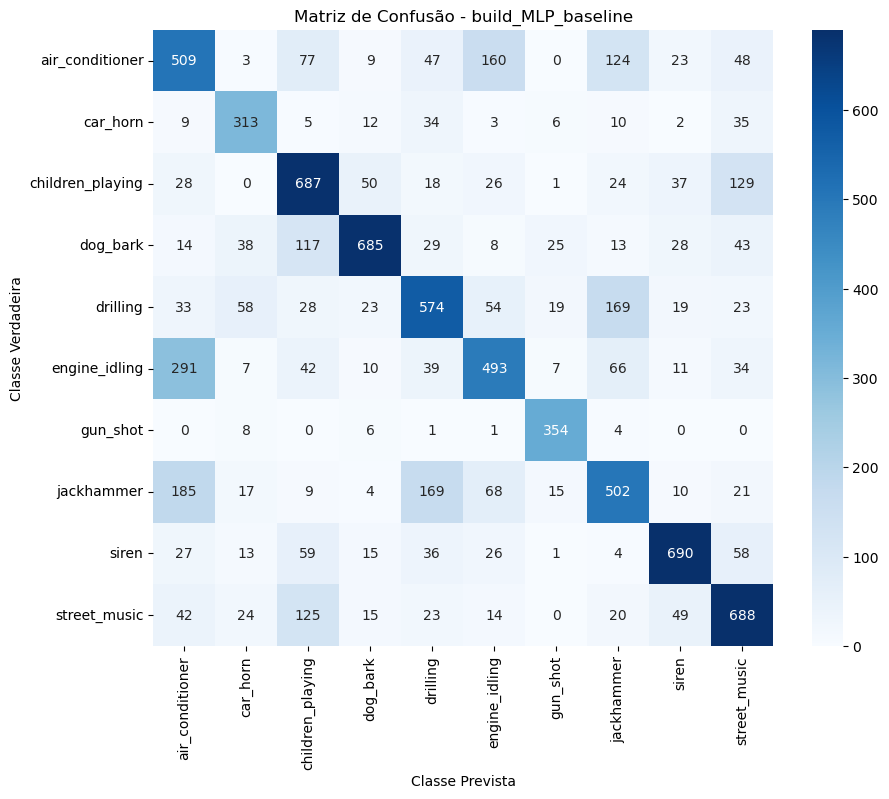


TESTE 1.2: FEATURES SIMPLES + RÍTMICAS
Experimento: build_MLP_baseline 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32

Fold 1/10 
Fold 1: Parou na Epoch nº 17
Fold 1: Accuracy do teste = 72.51%

Fold 2/10 
Fold 2: Parou na Epoch nº 27
Fold 2: Accuracy do teste = 61.15%

Fold 3/10 
Fold 3: Parou na Epoch nº 23
Fold 3: Accuracy do teste = 61.73%

Fold 4/10 
Fold 4: Parou na Epoch nº 20
Fold 4: Accuracy do teste = 62.83%

Fold 5/10 
Fold 5: Parou na Epoch nº 18
Fold 5: Accuracy do teste = 68.27%

Fold 6/10 
Fold 6: Parou na Epoch nº 26
Fold 6: Accuracy do teste = 66.46%

Fold 7/10 
Fold 7: Parou na Epoch nº 21
Fold 7: Accuracy do teste = 66.11%

Fold 8/10 
Fold 8: Parou na Epoch nº 16
Fold 8: Accuracy do teste = 63.40%

Fold 9/10 
Fold 9: Parou na Epoch nº 20
Fold 9: Accuracy do teste = 63.85%

Fold 10/10 
Fold 10: Parou na Epoch nº 13
Fold 10: Accuracy do teste = 64.40%

Resultados Finais do Experimento 
Accuracy Média: 65.07% (Std: 3.24%)

Relatório de Class

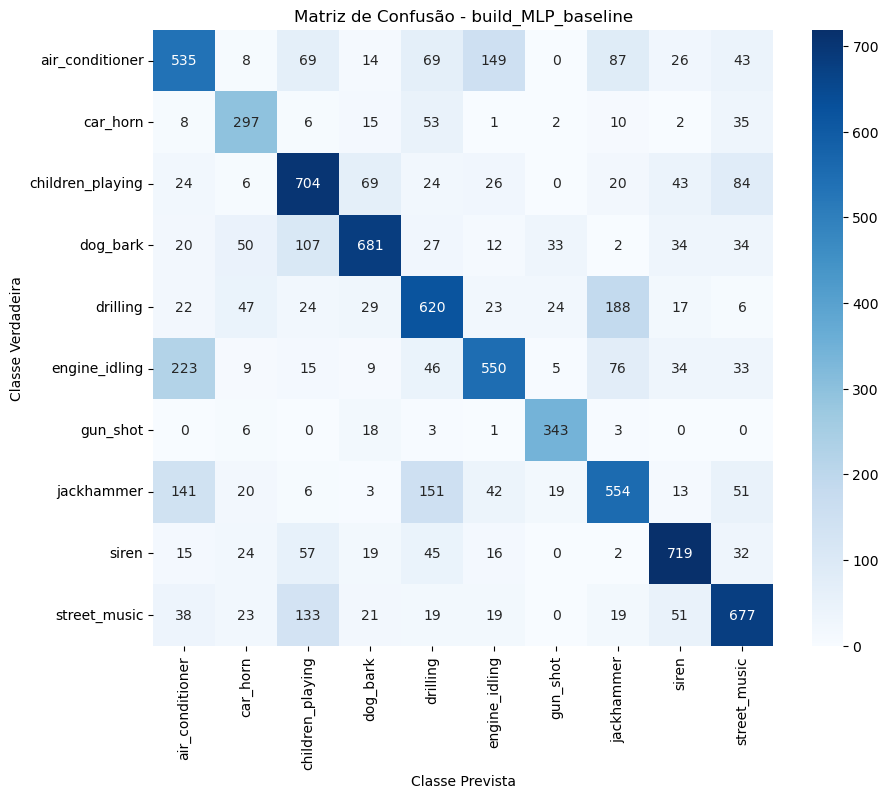


TESTE 1.3: FEATURES COMPLETAS
Experimento: build_MLP_baseline 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32

Fold 1/10 
Fold 1: Parou na Epoch nº 13
Fold 1: Accuracy do teste = 73.65%

Fold 2/10 
Fold 2: Parou na Epoch nº 18
Fold 2: Accuracy do teste = 59.68%

Fold 3/10 
Fold 3: Parou na Epoch nº 30
Fold 3: Accuracy do teste = 66.59%

Fold 4/10 
Fold 4: Parou na Epoch nº 29
Fold 4: Accuracy do teste = 67.78%

Fold 5/10 
Fold 5: Parou na Epoch nº 18
Fold 5: Accuracy do teste = 76.18%

Fold 6/10 
Fold 6: Parou na Epoch nº 23
Fold 6: Accuracy do teste = 64.03%

Fold 7/10 
Fold 7: Parou na Epoch nº 19
Fold 7: Accuracy do teste = 65.51%

Fold 8/10 
Fold 8: Parou na Epoch nº 15
Fold 8: Accuracy do teste = 59.93%

Fold 9/10 
Fold 9: Parou na Epoch nº 27
Fold 9: Accuracy do teste = 67.52%

Fold 10/10 
Fold 10: Parou na Epoch nº 21
Fold 10: Accuracy do teste = 72.52%

Resultados Finais do Experimento 
Accuracy Média: 67.34% (Std: 5.23%)

Relatório de Classificação 

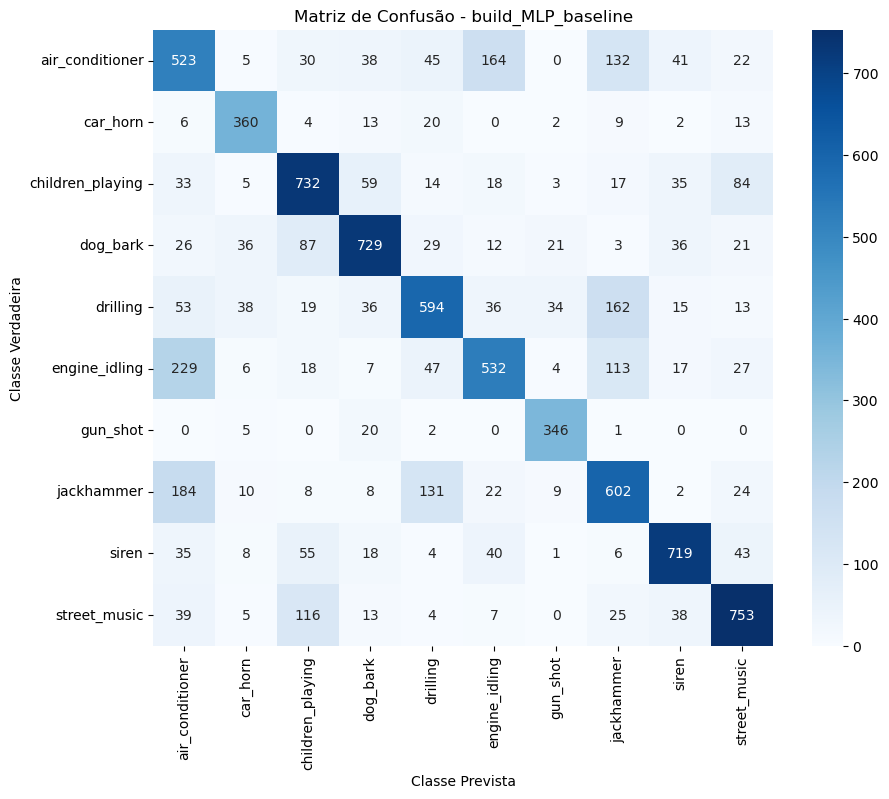

In [42]:
# Teste 1.1: Baseline com Features 'Simples'
print("\nTESTE 1.1: FEATURES SIMPLES")
# Extrai X, y, fold_values do df_simples
X = df_simples.drop(columns=['class', 'fold', 'file_name']).values
y = df_simples['class'].astype('category').cat.codes.values
class_names = df_simples['class'].astype('category').cat.categories
fold_values = df_simples['fold'].values
n_features = X.shape[1] # Atualiza n_features
n_classes = len(class_names)

run_experiment(
    model_builder_fn=build_MLP_baseline,
    hidden_units=256, learning_rate=0.001, dropout_rate=0.3
)

# Teste 1.2: Baseline com Features 'Simples + Rítmicas' 
print("\nTESTE 1.2: FEATURES SIMPLES + RÍTMICAS")
# Extrai X, y, fold_values do df_ritmicas
X = df_ritmicas.drop(columns=['class', 'fold', 'file_name']).values
y = df_ritmicas['class'].astype('category').cat.codes.values
class_names = df_ritmicas['class'].astype('category').cat.categories
fold_values = df_ritmicas['fold'].values
n_features = X.shape[1] # Atualiza n_features
n_classes = len(class_names)

run_experiment(
    model_builder_fn=build_MLP_baseline,
    hidden_units=256, learning_rate=0.001, dropout_rate=0.3
)

# Teste 1.3: Baseline com Features 'Completas' 
print("\nTESTE 1.3: FEATURES COMPLETAS")
# Extrai X, y, fold_values do df_completas
X = df_completas.drop(columns=['class', 'fold', 'file_name']).values
y = df_completas['class'].astype('category').cat.codes.values
class_names = df_completas['class'].astype('category').cat.categories
fold_values = df_completas['fold'].values
n_features = X.shape[1] # Atualiza n_features
n_classes = len(class_names)

run_experiment(
    model_builder_fn=build_MLP_baseline,
    hidden_units=256, learning_rate=0.001, dropout_rate=0.3
)

O conjunto de 'features completas' obteve a melhor performance média (Accuracy Média de 67.34%). Todas as otimizações seguintes serão feitas usando este conjunto de features.

### Seleção da arquitetura

**2. Testes das arquiteturas**

Com as features fixadas, testámos qual a melhor estratégia:
1.  **Baseline (Dropout)** 
2.  **Batch Normalization (Dropout + BN)** 
3.  **L2 Regularization (Dropout + L2)**

In [43]:
X = df_completas.drop(columns=['class', 'fold', 'file_name']).values
y = df_completas['class'].astype('category').cat.codes.values
class_names = df_completas['class'].astype('category').cat.categories
fold_values = df_completas['fold'].values
n_features = X.shape[1] # Atualiza n_features

##### Teste 2.1: Modelo Baseline 

O nosso ponto de partida (baseline) para esta fase é o resultado do Teste 1.3.

- Modelo: build_MLP_baseline

- Hiperparâmetros: hidden units=256, learning rate=0.001, dropout=0.3, batch=32

- Resultados: Accuracy Média (de 1.3): 67.34% (Std: 5.23%)

##### Teste 2.2: Modelo com Dropout + Batch Normalization

No segundo teste, avaliámos o impacto da Batch Normalization (BN). Mantivemos todos os outros hiperparâmetros da baseline, mas usámos uma arquitetura que adiciona uma camada de BN após cada ativação ReLU. 

Experimento: build_MLP_with_BN 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32

Fold 1/10 
Fold 1: Parou na Epoch nº 19
Fold 1: Accuracy do teste = 60.37%

Fold 2/10 
Fold 2: Parou na Epoch nº 19
Fold 2: Accuracy do teste = 61.82%

Fold 3/10 
Fold 3: Parou na Epoch nº 22
Fold 3: Accuracy do teste = 57.73%

Fold 4/10 
Fold 4: Parou na Epoch nº 30
Fold 4: Accuracy do teste = 68.79%

Fold 5/10 
Fold 5: Parou na Epoch nº 12
Fold 5: Accuracy do teste = 66.67%

Fold 6/10 
Fold 6: Parou na Epoch nº 13
Fold 6: Accuracy do teste = 66.22%

Fold 7/10 
Fold 7: Parou na Epoch nº 16
Fold 7: Accuracy do teste = 71.00%

Fold 8/10 
Fold 8: Parou na Epoch nº 21
Fold 8: Accuracy do teste = 65.26%

Fold 9/10 
Fold 9: Parou na Epoch nº 20
Fold 9: Accuracy do teste = 63.60%

Fold 10/10 
Fold 10: Parou na Epoch nº 12
Fold 10: Accuracy do teste = 70.49%

Resultados Finais do Experimento 
Accuracy Média: 65.20% (Std: 4.13%)

Relatório de Classificação (Global):
                  prec

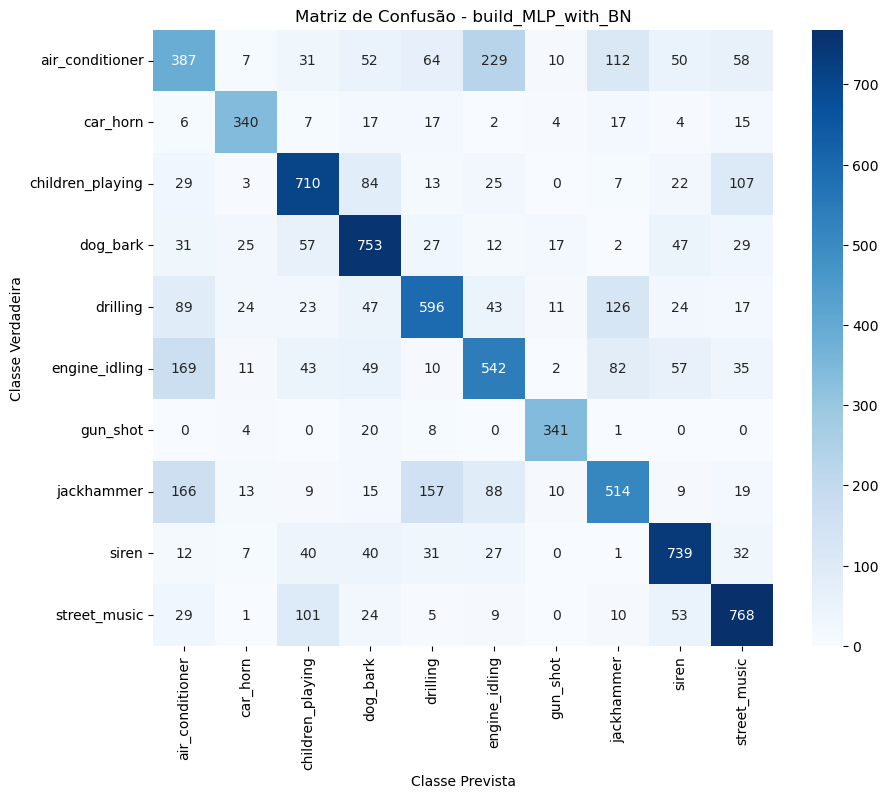

In [55]:
run_experiment(
    model_builder_fn = build_MLP_with_BN,
    hidden_units = 256,
    learning_rate = 0.001,
    dropout_rate = 0.3
)

A queda de performance observada ao combinar Dropout com Batch Normalization (BN) deve-se ao excesso de regularização. O BN já introduz ruído estatístico ao normalizar cada batch com médias e variâncias que variam, dificultando a memorização dos dados. Adicionar Dropout, que gera ruído estrutural desligando neurónios, amplifica esta perturbação, tornando o treino instável e prejudicando a aprendizagem. Este efeito, conhecido como variance shift, é descrito em Li et al., CVPR 2019 – “Understanding the Disharmony between Dropout and Batch Normalization”.

##### Teste 2.3: Modelo com  Dropout + Regularização L2 

Por último, testámos a técnica de regularização clássica L2 (Weight Regularization).
Começamos com um lambda de 0.001: é suficientemente pequeno para não impedir a aprendizagem dos padrões principais, mas suficientemente grande para penalizar pesos excessivamente altos.

Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 24
Fold 1: Accuracy do teste = 73.31%

Fold 2/10 
Fold 2: Parou na Epoch nº 25
Fold 2: Accuracy do teste = 62.95%

Fold 3/10 
Fold 3: Parou na Epoch nº 39
Fold 3: Accuracy do teste = 68.97%

Fold 4/10 
Fold 4: Parou na Epoch nº 25
Fold 4: Accuracy do teste = 68.18%

Fold 5/10 
Fold 5: Parou na Epoch nº 26
Fold 5: Accuracy do teste = 77.99%

Fold 6/10 
Fold 6: Parou na Epoch nº 35
Fold 6: Accuracy do teste = 68.53%

Fold 7/10 
Fold 7: Parou na Epoch nº 23
Fold 7: Accuracy do teste = 66.47%

Fold 8/10 
Fold 8: Parou na Epoch nº 32
Fold 8: Accuracy do teste = 62.53%

Fold 9/10 
Fold 9: Parou na Epoch nº 24
Fold 9: Accuracy do teste = 68.38%

Fold 10/10 
Fold 10: Parou na Epoch nº 17
Fold 10: Accuracy do teste = 69.41%

Resultados Finais do Experimento 
Accuracy Média: 68.67% (Std: 4.30%)

Relatório de Classificação (Global):
     

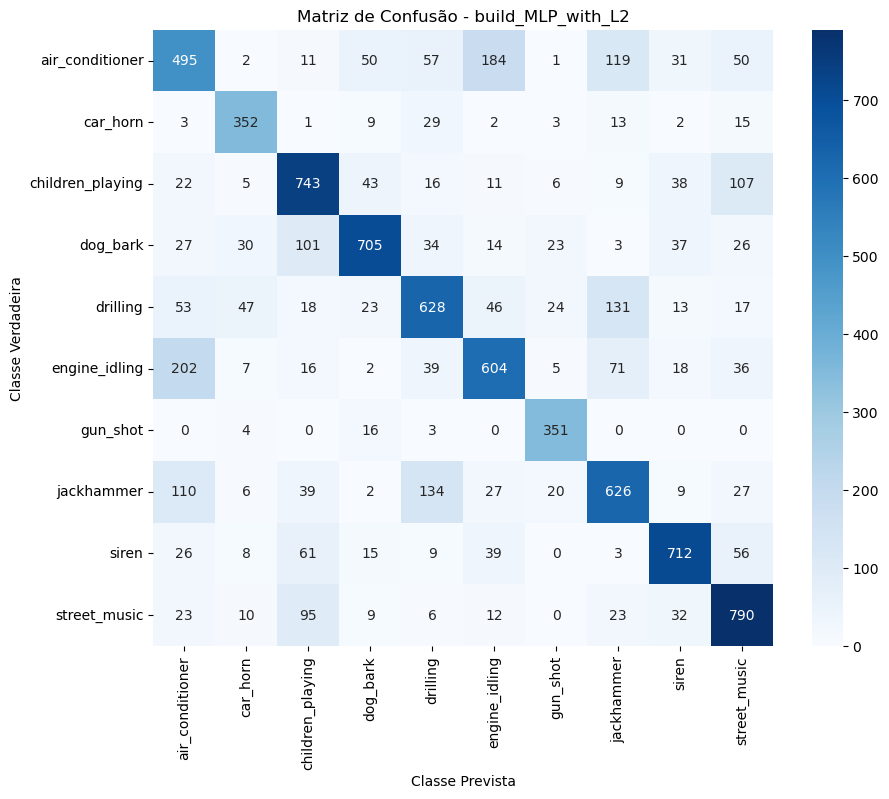

In [53]:
run_experiment(
    model_builder_fn = build_MLP_with_L2,
    hidden_units = 256,
    learning_rate = 0.001,
    dropout_rate = 0.3
)

**Conclusão da Fase 2:**
A arquitetura com **Regularização L2 (+ Dropout)** demonstrou ser superior, atingindo a melhor accuracy média. O Batch Normalization, neste caso específico, não trouxe melhorias significativas face à baseline.

### Otimização de parâmetros

**3. Testes de Hiperparâmetros**

Na etapa final, refinámos os hiperparâmetros do modelo vencedor (Dropout + L2).

In [56]:
X = df_completas.drop(columns=['class', 'fold', 'file_name']).values
y = df_completas['class'].astype('category').cat.codes.values
class_names = df_completas['class'].astype('category').cat.categories
fold_values = df_completas['fold'].values
n_features = X.shape[1]
n_classes = len(class_names)

print(f"Baseline para Fase 3 (Teste 2.3): Acc Média = 68.67%")

Baseline para Fase 3 (Teste 2.3): Acc Média = 68.67%


Tendo o Teste 2.3 como ponto de partida (Accuracy Média: 68.67%), o nosso primeiro passo foi testar diferentes valores de hidden units. 

##### Teste 3.1: Hidden units 

O objetivo deste teste foi avaliar a capacidade de representação do modelo. Redes maiores conseguem aprender relações mais complexas, mas também aumentam o risco de overfitting.


Teste hidden_units = 128
Experimento: build_MLP_with_L2 
Params: hidden units=128, learning rate=0.001, dropout=0.3, batch size=128
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 42
Fold 1: Accuracy do teste = 73.31%

Fold 2/10 
Fold 2: Parou na Epoch nº 26
Fold 2: Accuracy do teste = 58.00%

Fold 3/10 
Fold 3: Parou na Epoch nº 53
Fold 3: Accuracy do teste = 63.03%

Fold 4/10 
Fold 4: Parou na Epoch nº 47
Fold 4: Accuracy do teste = 67.78%

Fold 5/10 
Fold 5: Parou na Epoch nº 30
Fold 5: Accuracy do teste = 71.37%

Fold 6/10 
Fold 6: Parou na Epoch nº 51
Fold 6: Accuracy do teste = 68.77%

Fold 7/10 
Fold 7: Parou na Epoch nº 39
Fold 7: Accuracy do teste = 63.13%

Fold 8/10 
Fold 8: Parou na Epoch nº 23
Fold 8: Accuracy do teste = 61.79%

Fold 9/10 
Fold 9: Parou na Epoch nº 52
Fold 9: Accuracy do teste = 70.34%

Fold 10/10 
Fold 10: Parou na Epoch nº 24
Fold 10: Accuracy do teste = 73.72%

Resultados Finais do Experimento 
Accuracy Média: 67.12% (Std: 5.08%)

Relatório de Cl

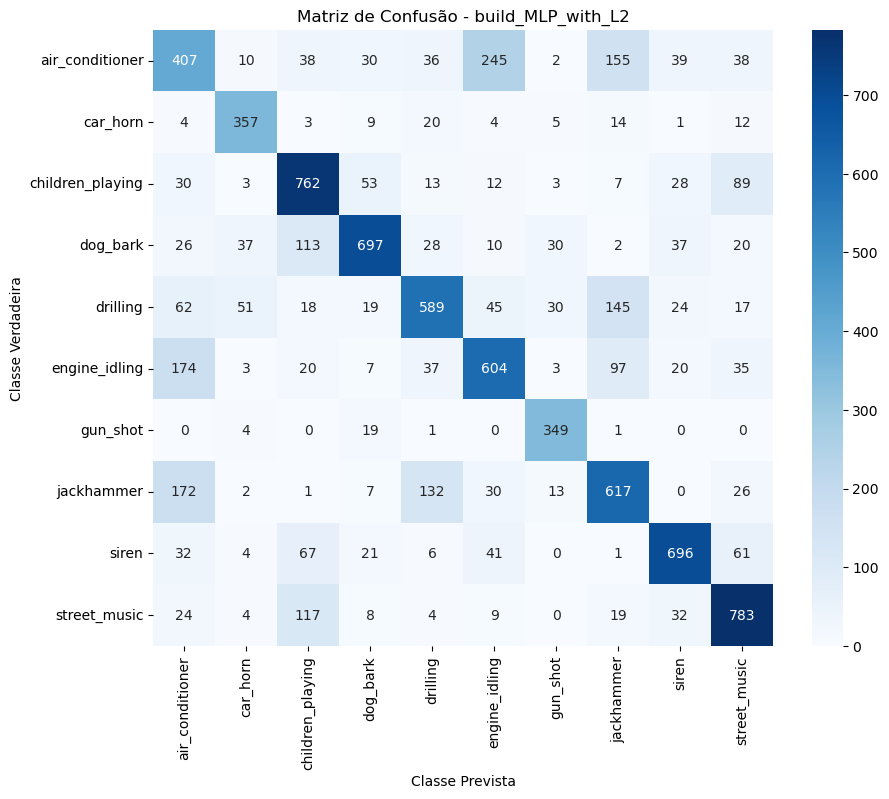


Teste hidden_units = 512
Experimento: build_MLP_with_L2 
Params: hidden units=512, learning rate=0.001, dropout=0.3, batch size=128
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 20
Fold 1: Accuracy do teste = 75.03%

Fold 2/10 
Fold 2: Parou na Epoch nº 25
Fold 2: Accuracy do teste = 61.49%

Fold 3/10 
Fold 3: Parou na Epoch nº 33
Fold 3: Accuracy do teste = 62.38%

Fold 4/10 
Fold 4: Parou na Epoch nº 52
Fold 4: Accuracy do teste = 67.47%

Fold 5/10 
Fold 5: Parou na Epoch nº 21
Fold 5: Accuracy do teste = 73.61%

Fold 6/10 
Fold 6: Parou na Epoch nº 46
Fold 6: Accuracy do teste = 70.35%

Fold 7/10 
Fold 7: Parou na Epoch nº 26
Fold 7: Accuracy do teste = 72.20%

Fold 8/10 
Fold 8: Parou na Epoch nº 38
Fold 8: Accuracy do teste = 62.90%

Fold 9/10 
Fold 9: Parou na Epoch nº 25
Fold 9: Accuracy do teste = 68.14%

Fold 10/10 
Fold 10: Parou na Epoch nº 22
Fold 10: Accuracy do teste = 68.82%

Resultados Finais do Experimento 
Accuracy Média: 68.24% (Std: 4.52%)

Relatório de Cl

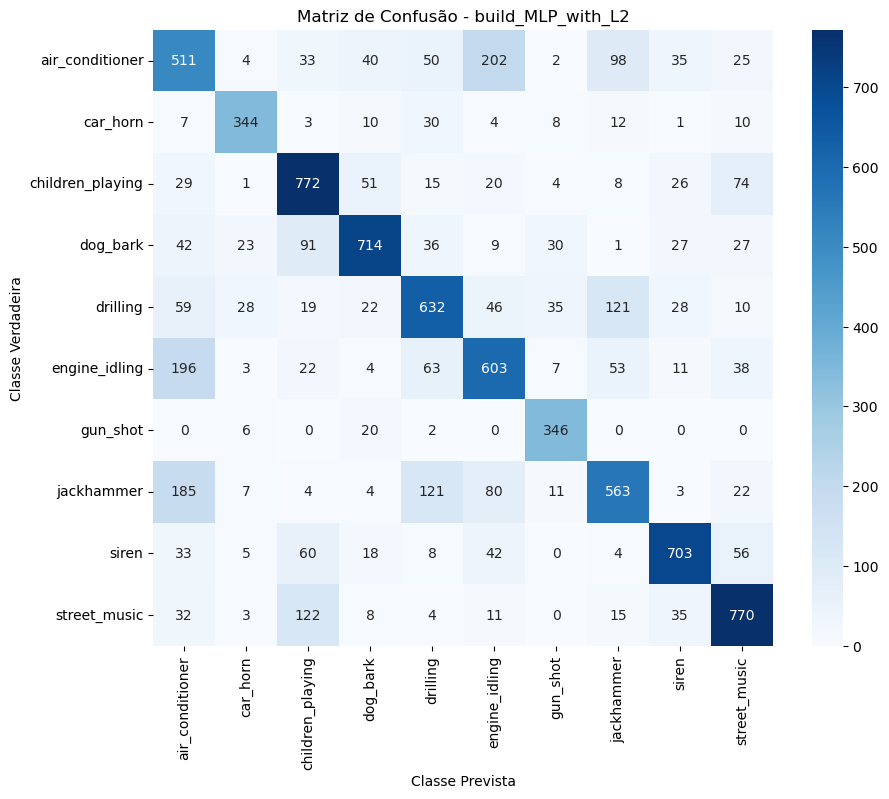

In [47]:
hidden_grid = [128, 512]  

for h in hidden_grid:
    print(f"\nTeste hidden_units = {h}")
    run_experiment(
        model_builder_fn=build_MLP_with_L2,  
        hidden_units=h,
        learning_rate=0.001,    
        dropout_rate=0.3,        
        batch_size=128,
        l2_lambda=0.001
    )

A alteração do número de unidades escondidas não trouxe melhorias ao modelo (128 - Acc. 67.12%, 512 - Acc. 68.24%). Assim, mantemos o valor original de 256 unidades, que continua a apresentar o melhor desempenho (Acc. - 68.67%).

##### Teste 3.2: Otimização de L2 (Teste L2 = 0.01) 

Aumentámos a intensidade da penalização L2 para ver se mais regularização melhora o modelo.

Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=32
L2 Lambda: 0.01

Fold 1/10 
Fold 1: Parou na Epoch nº 45
Fold 1: Accuracy do teste = 70.22%

Fold 2/10 
Fold 2: Parou na Epoch nº 46
Fold 2: Accuracy do teste = 57.09%

Fold 3/10 
Fold 3: Parou na Epoch nº 51
Fold 3: Accuracy do teste = 58.92%

Fold 4/10 
Fold 4: Parou na Epoch nº 61
Fold 4: Accuracy do teste = 62.93%

Fold 5/10 
Fold 5: Parou na Epoch nº 42
Fold 5: Accuracy do teste = 67.52%

Fold 6/10 
Fold 6: Parou na Epoch nº 46
Fold 6: Accuracy do teste = 60.27%

Fold 7/10 
Fold 7: Parou na Epoch nº 43
Fold 7: Accuracy do teste = 52.63%

Fold 8/10 
Fold 8: Parou na Epoch nº 30
Fold 8: Accuracy do teste = 58.81%

Fold 9/10 
Fold 9: Parou na Epoch nº 42
Fold 9: Accuracy do teste = 66.79%

Fold 10/10 
Fold 10: Parou na Epoch nº 39
Fold 10: Accuracy do teste = 64.52%

Resultados Finais do Experimento 
Accuracy Média: 61.97% (Std: 5.13%)

Relatório de Classificação (Global):
      

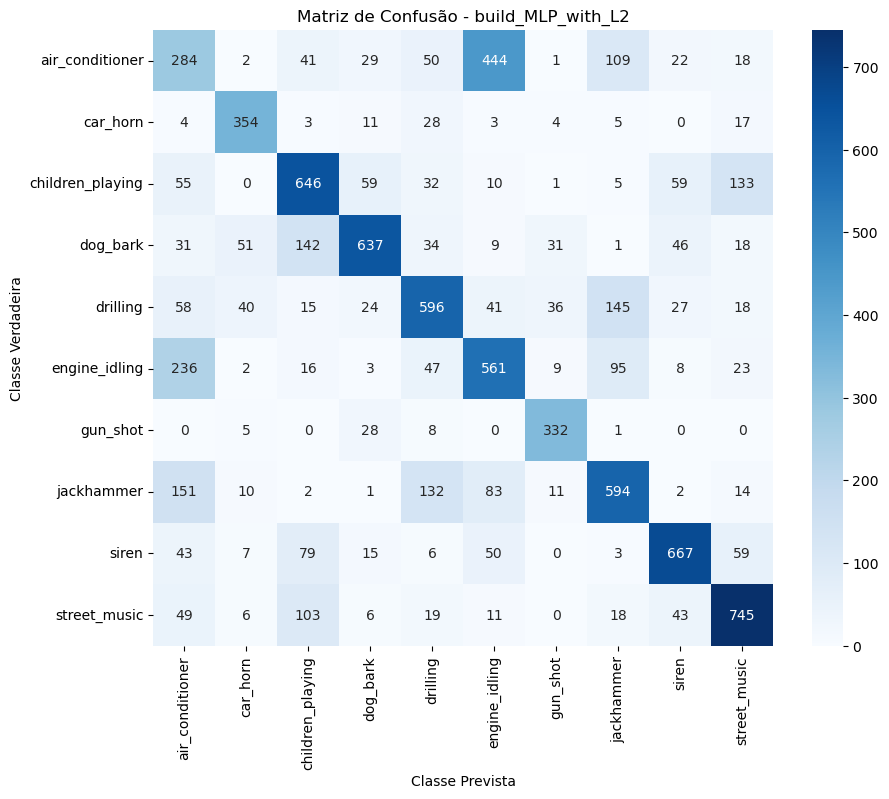

In [57]:
run_experiment(
    model_builder_fn=build_MLP_with_L2,
    hidden_units=256, 
    learning_rate=0.001, 
    dropout_rate=0.3,
    batch_size=32,
    l2_lambda=0.01  
)

Aumentar o l2_lambda para 0.01 causa um excesso de regularização e uma quebra na performance (Accuracy Média de 61.97%). Isto confirma que o valor baseline de l2_lambda=0.001 é uma escolha superior.

##### Teste 3.3: Otimização de Dropout

O dropout atua desligando aleatoriamente neurónios durante o treino, forçando a rede a não depender excessivamente de caminhos específicos. Isto torna o modelo mais robusto e reduz co-adaptações internas, combatendo overfitting. Testar diferentes probabilidades permite encontrar o nível ideal de regularização.


Teste dropout_rate = 0.1
Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.1, batch size=32
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 20
Fold 1: Accuracy do teste = 71.59%

Fold 2/10 
Fold 2: Parou na Epoch nº 21
Fold 2: Accuracy do teste = 62.84%

Fold 3/10 
Fold 3: Parou na Epoch nº 29
Fold 3: Accuracy do teste = 63.14%

Fold 4/10 
Fold 4: Parou na Epoch nº 25
Fold 4: Accuracy do teste = 65.15%

Fold 5/10 
Fold 5: Parou na Epoch nº 17
Fold 5: Accuracy do teste = 72.22%

Fold 6/10 
Fold 6: Parou na Epoch nº 28
Fold 6: Accuracy do teste = 70.35%

Fold 7/10 
Fold 7: Parou na Epoch nº 22
Fold 7: Accuracy do teste = 69.69%

Fold 8/10 
Fold 8: Parou na Epoch nº 25
Fold 8: Accuracy do teste = 60.17%

Fold 9/10 
Fold 9: Parou na Epoch nº 18
Fold 9: Accuracy do teste = 68.75%

Fold 10/10 
Fold 10: Parou na Epoch nº 14
Fold 10: Accuracy do teste = 68.82%

Resultados Finais do Experimento 
Accuracy Média: 67.27% (Std: 3.93%)

Relatório de Cla

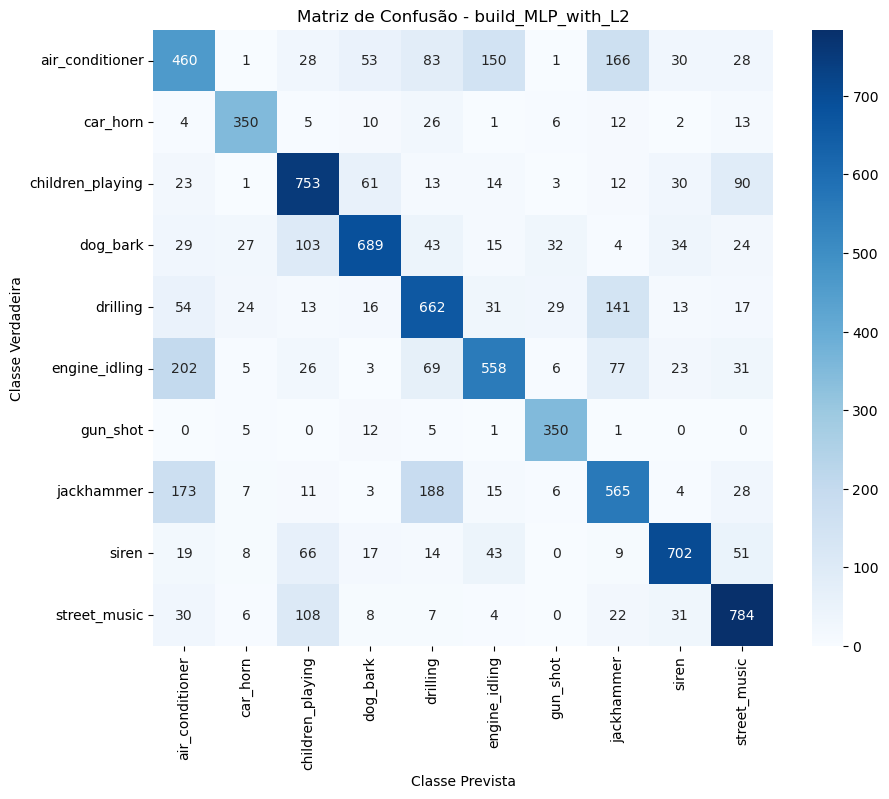


Teste dropout_rate = 0.2
Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.2, batch size=32
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 30
Fold 1: Accuracy do teste = 68.61%

Fold 2/10 
Fold 2: Parou na Epoch nº 19
Fold 2: Accuracy do teste = 59.35%

Fold 3/10 
Fold 3: Parou na Epoch nº 30
Fold 3: Accuracy do teste = 64.97%

Fold 4/10 
Fold 4: Parou na Epoch nº 23
Fold 4: Accuracy do teste = 62.83%

Fold 5/10 
Fold 5: Parou na Epoch nº 16
Fold 5: Accuracy do teste = 74.47%

Fold 6/10 
Fold 6: Parou na Epoch nº 38
Fold 6: Accuracy do teste = 70.23%

Fold 7/10 
Fold 7: Parou na Epoch nº 21
Fold 7: Accuracy do teste = 65.87%

Fold 8/10 
Fold 8: Parou na Epoch nº 21
Fold 8: Accuracy do teste = 60.30%

Fold 9/10 
Fold 9: Parou na Epoch nº 22
Fold 9: Accuracy do teste = 68.75%

Fold 10/10 
Fold 10: Parou na Epoch nº 20
Fold 10: Accuracy do teste = 69.18%

Resultados Finais do Experimento 
Accuracy Média: 66.46% (Std: 4.47%)

Relatório de Cla

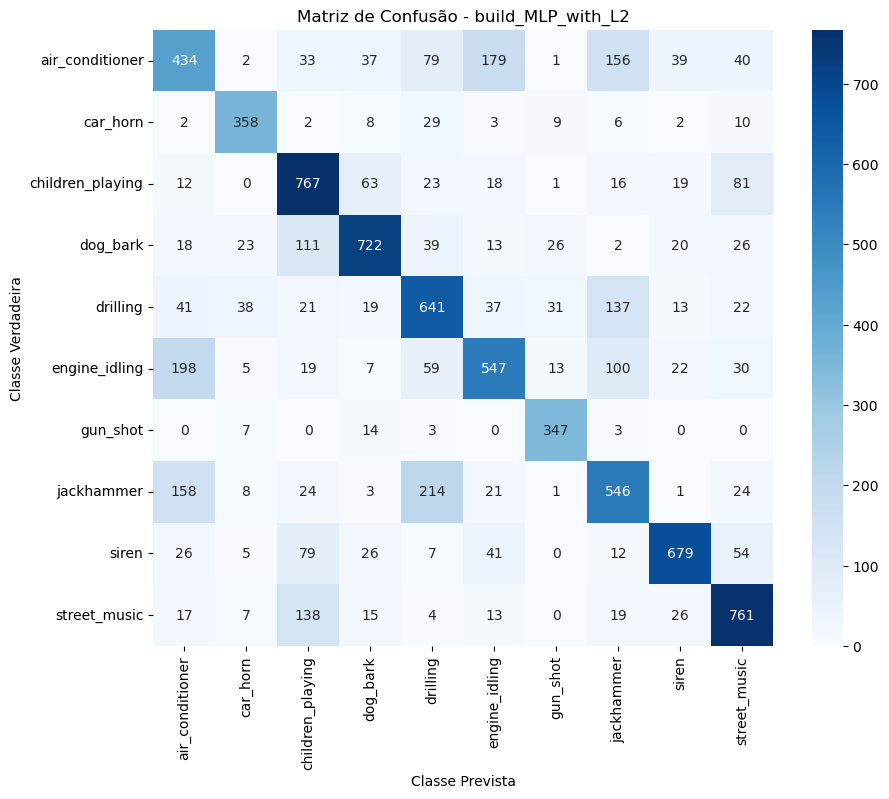


Teste dropout_rate = 0.5
Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.5, batch size=32
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 20
Fold 1: Accuracy do teste = 74.34%

Fold 2/10 
Fold 2: Parou na Epoch nº 23
Fold 2: Accuracy do teste = 59.46%

Fold 3/10 
Fold 3: Parou na Epoch nº 42
Fold 3: Accuracy do teste = 63.46%

Fold 4/10 
Fold 4: Parou na Epoch nº 39
Fold 4: Accuracy do teste = 68.59%

Fold 5/10 
Fold 5: Parou na Epoch nº 27
Fold 5: Accuracy do teste = 73.29%

Fold 6/10 
Fold 6: Parou na Epoch nº 28
Fold 6: Accuracy do teste = 64.03%

Fold 7/10 
Fold 7: Parou na Epoch nº 31
Fold 7: Accuracy do teste = 67.90%

Fold 8/10 
Fold 8: Parou na Epoch nº 17
Fold 8: Accuracy do teste = 59.68%

Fold 9/10 
Fold 9: Parou na Epoch nº 35
Fold 9: Accuracy do teste = 67.65%

Fold 10/10 
Fold 10: Parou na Epoch nº 30
Fold 10: Accuracy do teste = 69.89%

Resultados Finais do Experimento 
Accuracy Média: 66.83% (Std: 4.87%)

Relatório de Cla

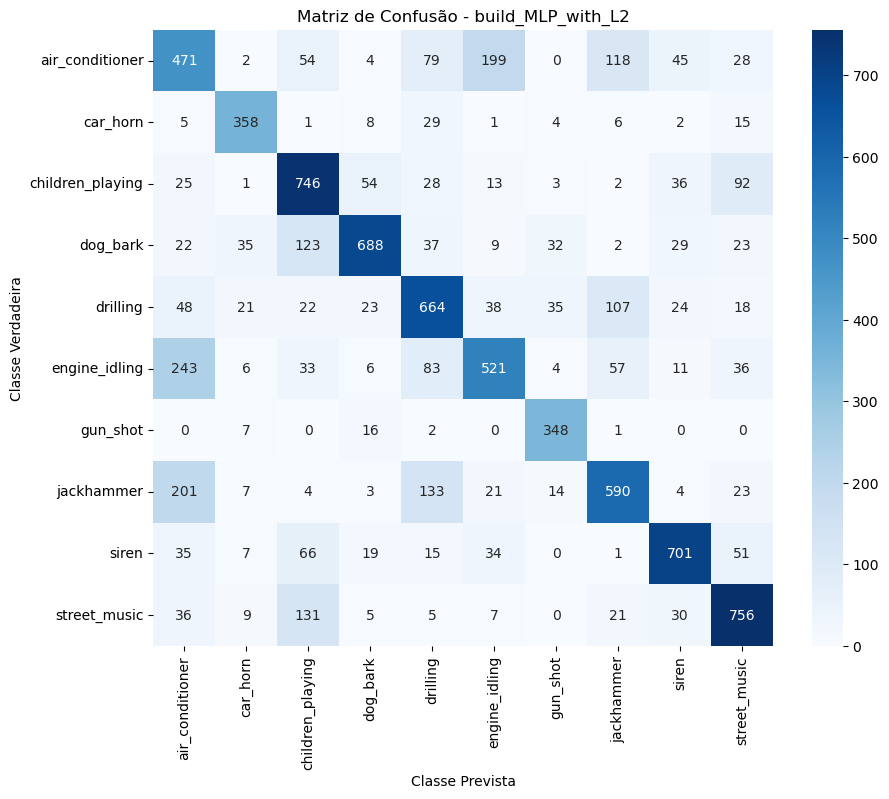

In [58]:
dr = [0.1, 0.2, 0.5]  

for d in dr:
    print(f"\nTeste dropout_rate = {d}")
    run_experiment(
        model_builder_fn=build_MLP_with_L2,  
        hidden_units=256,
        learning_rate=0.001,    
        dropout_rate=d,        
        batch_size=32,
        l2_lambda=0.001
    )

Valores mais baixos ou mais altos de dropout degradaram a performance. Concluímos que 0.3 continua a ser a taxa mais equilibrada para evitar overfitting sem prejudicar a aprendizagem.

##### Teste 3.4: Otimização de Batch Size 

Mudámos o batch size porque tamanho do batch afeta a qualidade das estimativas de gradiente e a estabilidade do treino: batches maiores tendem a produzir gradientes mais estáveis e melhor convergência prática.

Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.001, dropout=0.3, batch size=128
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 26
Fold 1: Accuracy do teste = 73.31%

Fold 2/10 
Fold 2: Parou na Epoch nº 26
Fold 2: Accuracy do teste = 63.63%

Fold 3/10 
Fold 3: Parou na Epoch nº 45
Fold 3: Accuracy do teste = 64.32%

Fold 4/10 
Fold 4: Parou na Epoch nº 60
Fold 4: Accuracy do teste = 70.10%

Fold 5/10 
Fold 5: Parou na Epoch nº 31
Fold 5: Accuracy do teste = 79.49%

Fold 6/10 
Fold 6: Parou na Epoch nº 37
Fold 6: Accuracy do teste = 69.50%

Fold 7/10 
Fold 7: Parou na Epoch nº 30
Fold 7: Accuracy do teste = 70.17%

Fold 8/10 
Fold 8: Parou na Epoch nº 27
Fold 8: Accuracy do teste = 65.51%

Fold 9/10 
Fold 9: Parou na Epoch nº 41
Fold 9: Accuracy do teste = 68.63%

Fold 10/10 
Fold 10: Parou na Epoch nº 34
Fold 10: Accuracy do teste = 71.33%

Resultados Finais do Experimento 
Accuracy Média: 69.60% (Std: 4.43%)

Relatório de Classificação (Global):
    

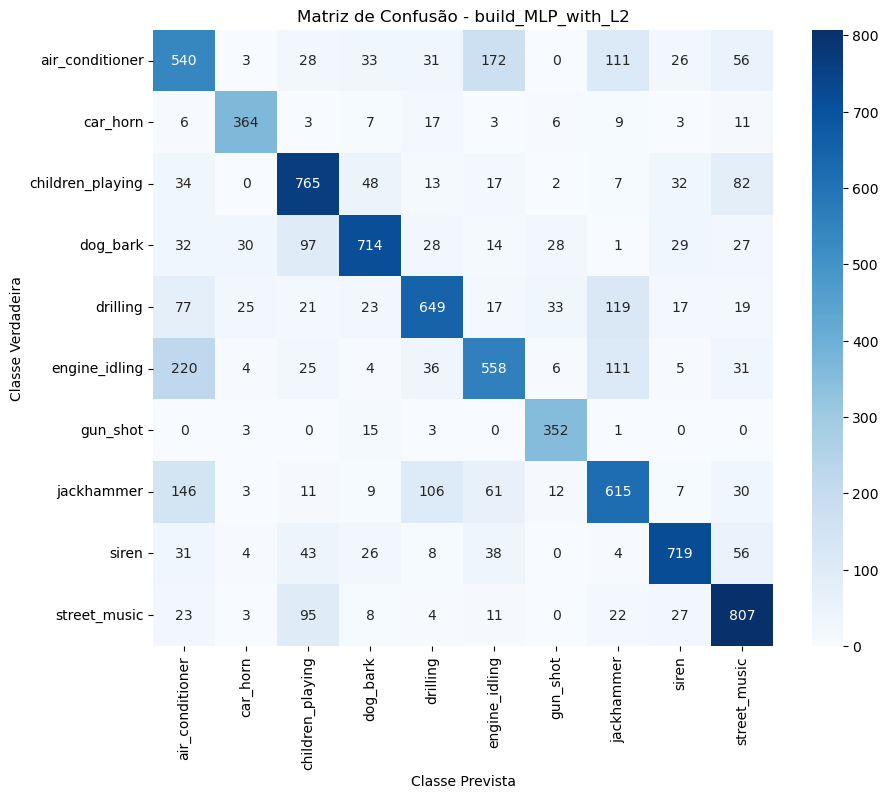

In [59]:
run_experiment(
    model_builder_fn = build_MLP_with_L2,
    hidden_units = 256,
    learning_rate = 0.001,
    dropout_rate = 0.3,
    batch_size = 128, 
    l2_lambda = 0.001
)

O aumento do batch size para 128 melhorou consistentemente os resultados (Accuracy Média de 69.60%), tornando-se uma atualização vantajosa face ao valor original (32).

##### Teste 3.5: Batch 128 com Learning Rate Menor (0.0001)

Ajustámos o learning rate para controlar a velocidade e estabilidade da otimização — rates mais baixos permitem convergência mais suave, rates mais altos aceleram treino mas podem provocar oscilações.

Experimento: build_MLP_with_L2 
Params: hidden units=256, learning rate=0.0001, dropout=0.3, batch size=128
L2 Lambda: 0.001

Fold 1/10 
Fold 1: Parou na Epoch nº 100
Fold 1: Accuracy do teste = 76.75%

Fold 2/10 
Fold 2: Parou na Epoch nº 72
Fold 2: Accuracy do teste = 63.85%

Fold 3/10 
Fold 3: Parou na Epoch nº 100
Fold 3: Accuracy do teste = 64.54%

Fold 4/10 
Fold 4: Parou na Epoch nº 100
Fold 4: Accuracy do teste = 68.28%

Fold 5/10 
Fold 5: Parou na Epoch nº 76
Fold 5: Accuracy do teste = 75.53%

Fold 6/10 
Fold 6: Parou na Epoch nº 100
Fold 6: Accuracy do teste = 69.62%

Fold 7/10 
Fold 7: Parou na Epoch nº 100
Fold 7: Accuracy do teste = 71.24%

Fold 8/10 
Fold 8: Parou na Epoch nº 90
Fold 8: Accuracy do teste = 66.50%

Fold 9/10 
Fold 9: Parou na Epoch nº 100
Fold 9: Accuracy do teste = 69.24%

Fold 10/10 
Fold 10: Parou na Epoch nº 96
Fold 10: Accuracy do teste = 71.68%

Resultados Finais do Experimento 
Accuracy Média: 69.72% (Std: 4.04%)

Relatório de Classificação (Global

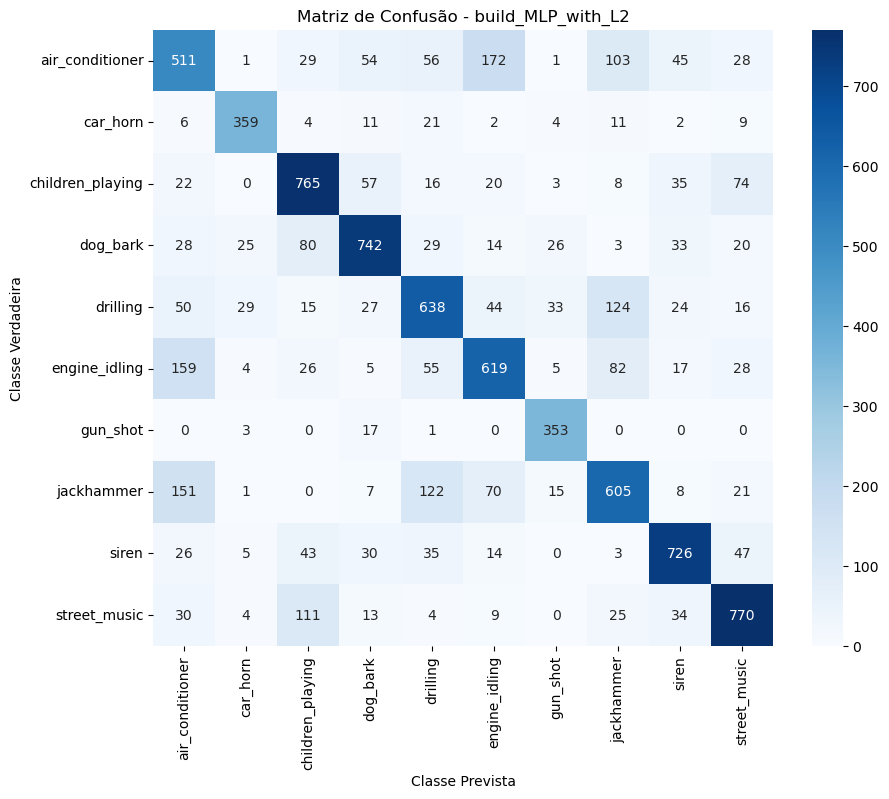

In [60]:
run_experiment(
    model_builder_fn = build_MLP_with_L2,
    hidden_units = 256,
    learning_rate = 0.0001, 
    dropout_rate = 0.3,     
    batch_size = 128,       
    l2_lambda = 0.001
)


Reduzir o learning rate para 0.0001 trouxe uma melhoria adicional. Observámos que o treino atingiu o limite de 100 épocas em vários folds, sugerindo um treino mais estável mas mais lento. Este valor torna-se o novo padrão para o modelo otimizado.

## Conclusão

O melhor modelo encontrado mantém a arquitetura base (3 camadas ocultas, 256 unidades) com Dropout = 0.3 e L2 = 0.001, mas com ajustes de treino que melhoraram a generalização: batch size = 128 e learning rate = 0.0001.

Esta configuração atingiu a melhor accuracy média (69.72%) na validação cruzada. Em síntese, as maiores melhorias não vieram de aumentar a capacidade da rede, mas sim de estabilizar e refinar o processo de treino (gradientes mais estáveis e convergência mais lenta/controlada), o que reduz ruído nas atualizações e melhora generalização. 

A análise detalhada das métricas revela um padrão claro na capacidade do modelo:

- Sucesso em Eventos Distintos: O modelo demonstra excelente capacidade discriminativa em sons com assinaturas tímbricas únicas e impulsivas, como Gun_shot (F1: 0.87) e Car_horn (F1: 0.83).

- Desafio em Sons Estacionários: Por oposição, a performance degrada-se em classes com texturas de ruído contínuo, como Air_conditioner (F1: 0.52), que é frequentemente confundido com Engine_idling. Esta limitação valida a nossa hipótese inicial de que a perda de informação temporal (ao usar médias de features) dificulta a distinção entre fontes sonoras estacionárias semelhantes.

## Bibliografia

Mishra, S., & Sahu, A. (2023). *A Review on Dropout Regularization Approaches for Deep Neural Networks.* MDPI Electronics, 12(3).

*Multilayer Perceptron Explained & How To Train MLPs.* 

Machine Learning II — *T04: Regularization and Advanced Training Techniques.*

Li et al., CVPR 2019. *Understanding the Disharmony between Dropout and Batch Normalization*